In [4]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import matplotlib.pyplot as plt
import os

In [5]:
data_dir = 'datasets/id001_ac'
results_dir = 'results/exp10/exp10.8'
fit_data_dir = f'{results_dir}/Rfiles'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

mdld_data = np.load(f'{data_dir}/AC_fit_trgt.npz')['fit_trgt']
mdld_data_ds = mdld_data[0:-1:20,:]

In [3]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = mdld_data_ds.shape[0]
I1 = 3.1
tau0 = 30.0

stan_fname = 'vep-snsrfit-cntr'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

for sigma in np.array([0.001, 0.01, 0.1]):
    for epsilon in np.array([0.01, 0.001, 0.1]):
        data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 
                'K':K, 'gain': gain_mat, 'sigma':sigma, 'epsilon':epsilon, 'slp':mdld_data_ds}
        input_Rfile = f'fit_data_sigma{sigma:0.5f}_eps{epsilon:0.5f}.R'
        os.makedirs(fit_data_dir,exist_ok=True)
        lib.io.stan.rdump(f'{fit_data_dir}/{input_Rfile}',data)
#         nchains = 4
#         with open('vep-snsrfit-cntr-advi.sh','r') as fd:
#             slurm_script = fd.read().format(f'{results_dir}/Rfiles', results_dir, input_Rfile, nchains, sigma, epsilon)
#         with open(f'tmp/vep-snsrfit-cntr-advi-sigma{sigma:0.5f}_epsilon{epsilon:0.5f}.sh','w') as fd:
#             fd.write(slurm_script)
#         lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-ode-sigma{sigma:0.5f}_eps{epsilon:0.5f}.sh'],block=False)

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/vep-snsrfit-cntr' is up to date.


In [ ]:
%%bash -s "$results_dir" "$input_Rfile" "$sigma" "$epsilon"
RESULTS_DIR=$1
INPUT_RFILE=$2
SIGMA=$(printf "%.5f" ${3})
EPSILON=$(printf "%.5f" ${4})
./vep-snsrfit-cntr variational iter=1000000 tol_rel_obj=0.01 \
output_samples=1000 data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
output file=${RESULTS_DIR}/samples_sigma${SIGMA}_eps${EPSILON}.csv \
&> ${RESULTS_DIR}/logs/snsrfit_cntr_sigma${SIGMA}_epsilon${EPSILON}.log

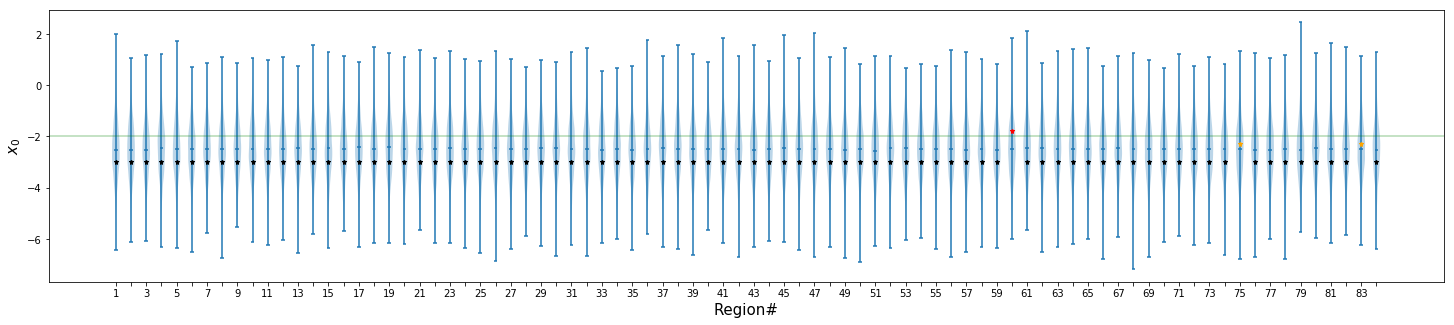

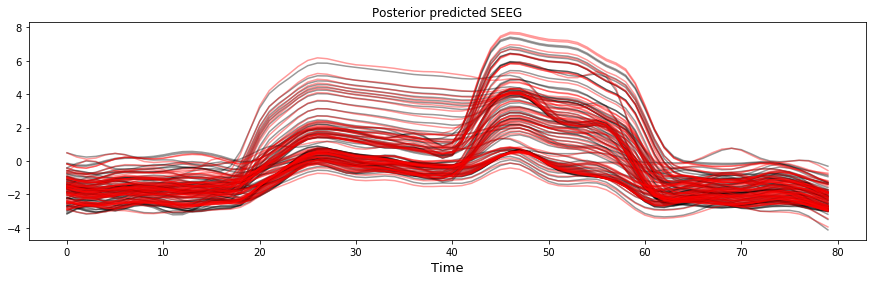

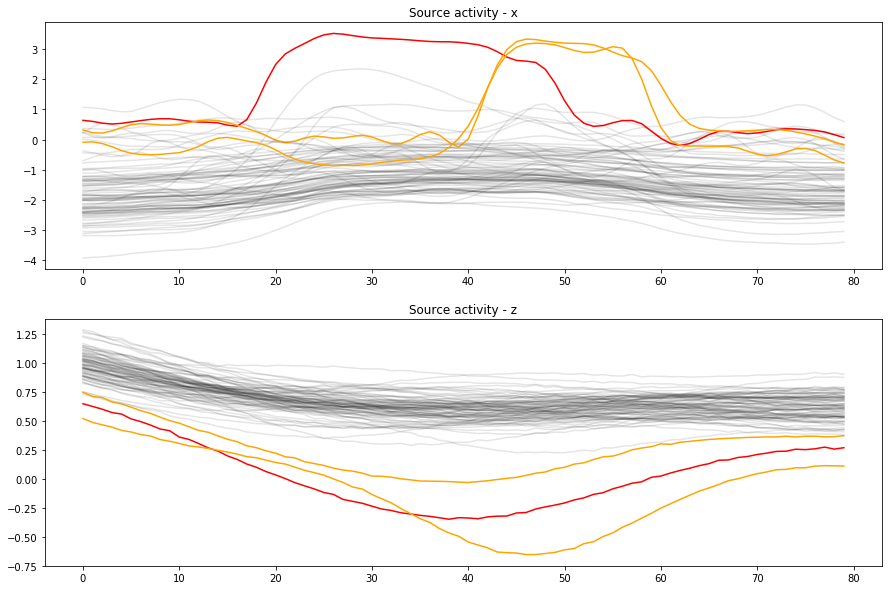

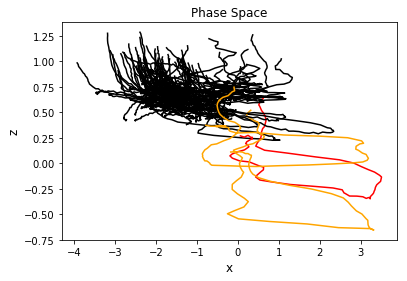

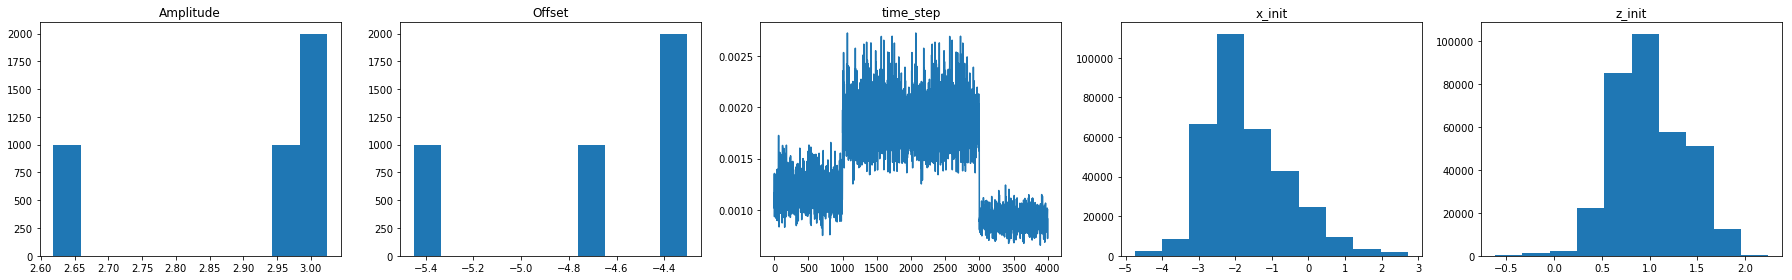

In [14]:
import importlib
importlib.reload(lib.io.stan)

nChains = 4
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_sigma0.10000_\
eps0.10000_chain{i+1}.csv' for i in range(nChains)])

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

lib.plots.stan.x0_violin(pstr_samples_1['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_sigma0.10000_eps0.10000.png')

ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude']
offset = pstr_samples_1['offset']
slp = np.zeros([src_sig.shape[0],src_sig.shape[1],gain.shape[0]])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])

slp_mean = np.mean(slp, axis=0)

mdld_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')
plt.figure(figsize=(15,4))
plt.plot(mdld_data_ds,'k',alpha=0.4);
plt.plot(slp_mean, 'r', alpha=0.4);
plt.title('Posterior predicted SEEG')
plt.xlabel('Time', fontsize=13)
plt.savefig(f'{results_dir}/figures/ppc_sigma0.10000_eps0.10000.png')


x_mean = np.mean(pstr_samples_1['x'], axis=0)
z_mean = np.mean(pstr_samples_1['z'], axis=0)

plt.figure(figsize=(15, 10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(x_mean[:, i], color='red');
        ax_src_z.plot(z_mean[:, i], color='red');
    elif i in pz:
        ax_src_x.plot(x_mean[:, i], color='orange');
        ax_src_z.plot(z_mean[:, i], color='orange');
    else:
        ax_src_x.plot(x_mean[:, i], color='black', alpha=0.1);
        ax_src_z.plot(z_mean[:, i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")
plt.savefig(f'{results_dir}/figures/src_inferred_sigma0.10000_eps0.10000.png')

plt.figure()
for i in range(84):
    if i in ez: 
        plt.plot(x_mean[:, i], z_mean[:, i], color='red')
    elif i in pz:
        plt.plot(x_mean[:, i], z_mean[:, i], color='orange')
    else:
        plt.plot(x_mean[:, i], z_mean[:, i], color='black')
plt.xlabel('x', fontsize=12.0)
plt.ylabel('z', fontsize=12.0)
plt.title('Phase Space')


plt.figure(figsize=(25,4))
plt.subplot(151)
plt.hist(pstr_samples_1['amplitude'].flatten())
plt.title('Amplitude')
plt.subplot(152)
plt.hist(pstr_samples_1['offset'].flatten())
plt.title('Offset')
plt.subplot(153)
plt.plot(pstr_samples_1['time_step'])
plt.title('time_step')
plt.subplot(154)
plt.hist(pstr_samples_1['x_init'].flatten())
plt.title('x_init')
plt.subplot(155)
plt.hist(pstr_samples_1['z_init'].flatten())
plt.title('z_init')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/other_params_sigma0.10000_eps0.10000.png')

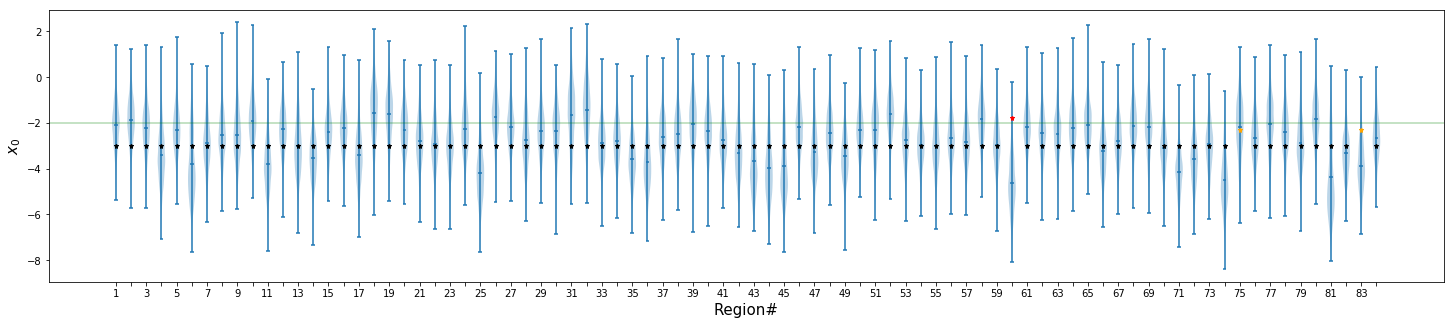

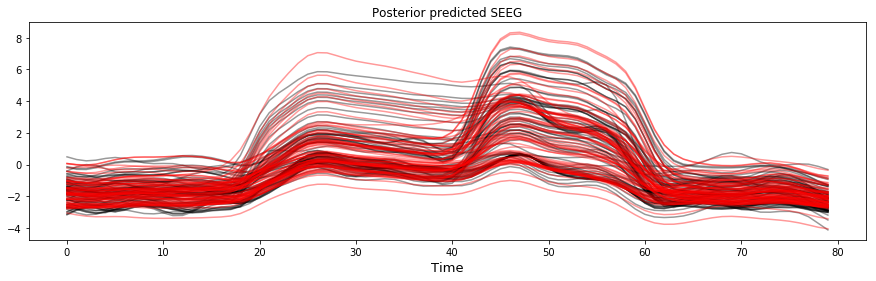

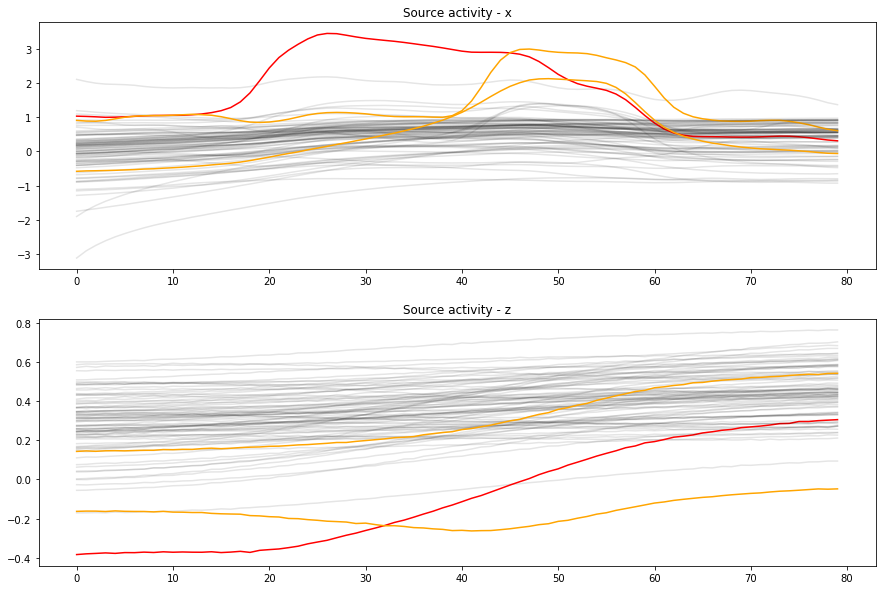

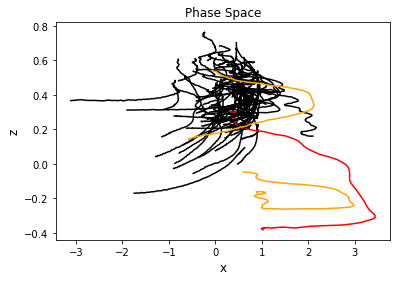

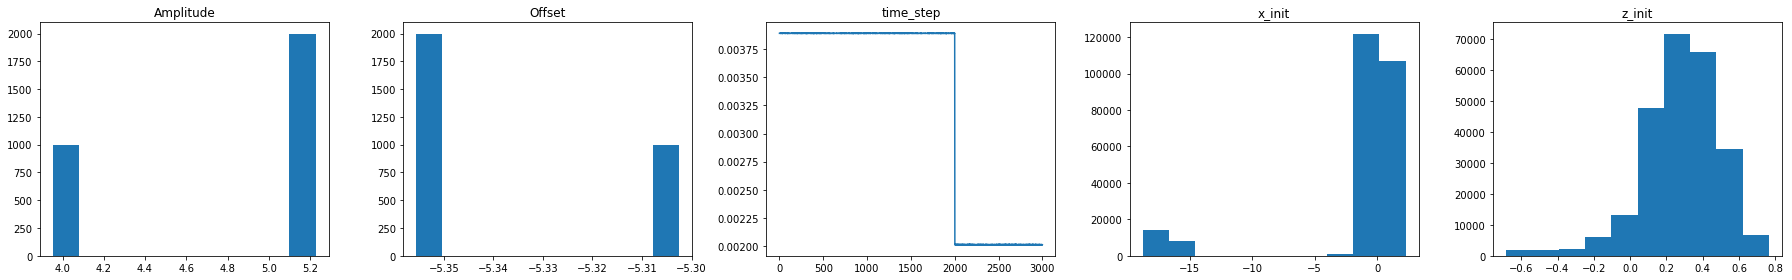

In [16]:
import importlib
importlib.reload(lib.io.stan)

nChains = 4
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_sigma0.01000_\
eps0.10000_chain{i+1}.csv' for i in range(1,nChains)])

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

lib.plots.stan.x0_violin(pstr_samples_1['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_sigma0.01000_eps0.10000.png')

ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude']
offset = pstr_samples_1['offset']
slp = np.zeros([src_sig.shape[0],src_sig.shape[1],gain.shape[0]])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])

slp_mean = np.mean(slp, axis=0)

mdld_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')
plt.figure(figsize=(15,4))
plt.plot(mdld_data_ds,'k',alpha=0.4);
plt.plot(slp_mean, 'r', alpha=0.4);
plt.title('Posterior predicted SEEG')
plt.xlabel('Time', fontsize=13)
plt.savefig(f'{results_dir}/figures/ppc_sigma0.01000_eps0.10000.png')


x_mean = np.mean(pstr_samples_1['x'], axis=0)
z_mean = np.mean(pstr_samples_1['z'], axis=0)

plt.figure(figsize=(15, 10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(x_mean[:, i], color='red');
        ax_src_z.plot(z_mean[:, i], color='red');
    elif i in pz:
        ax_src_x.plot(x_mean[:, i], color='orange');
        ax_src_z.plot(z_mean[:, i], color='orange');
    else:
        ax_src_x.plot(x_mean[:, i], color='black', alpha=0.1);
        ax_src_z.plot(z_mean[:, i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")
plt.savefig(f'{results_dir}/figures/src_inferred_sigma0.01000_eps0.10000.png')

plt.figure()
for i in range(84):
    if i in ez: 
        plt.plot(x_mean[:, i], z_mean[:, i], color='red')
    elif i in pz:
        plt.plot(x_mean[:, i], z_mean[:, i], color='orange')
    else:
        plt.plot(x_mean[:, i], z_mean[:, i], color='black')
plt.xlabel('x', fontsize=12.0)
plt.ylabel('z', fontsize=12.0)
plt.title('Phase Space')


plt.figure(figsize=(25,4))
plt.subplot(151)
plt.hist(pstr_samples_1['amplitude'].flatten())
plt.title('Amplitude')
plt.subplot(152)
plt.hist(pstr_samples_1['offset'].flatten())
plt.title('Offset')
plt.subplot(153)
plt.plot(pstr_samples_1['time_step'])
plt.title('time_step')
plt.subplot(154)
plt.hist(pstr_samples_1['x_init'].flatten())
plt.title('x_init')
plt.subplot(155)
plt.hist(pstr_samples_1['z_init'].flatten())
plt.title('z_init')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/other_params_sigma0.01000_eps0.10000.png')


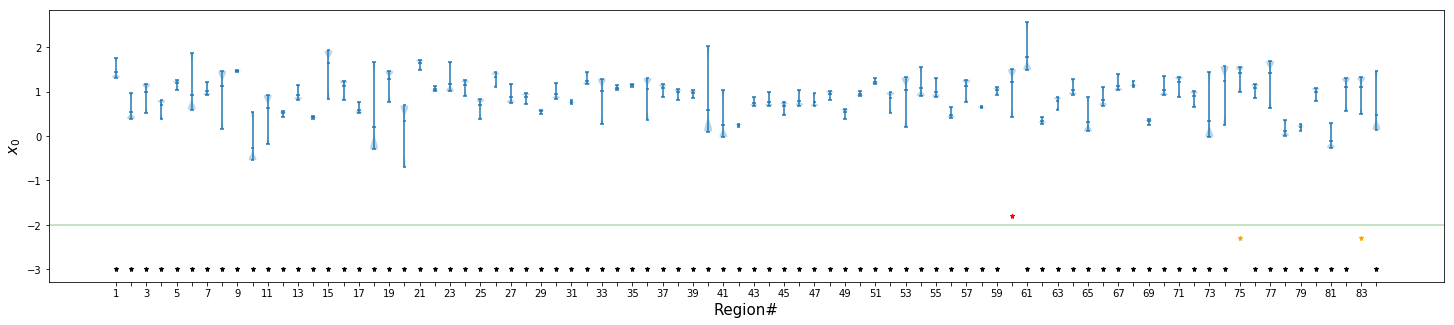

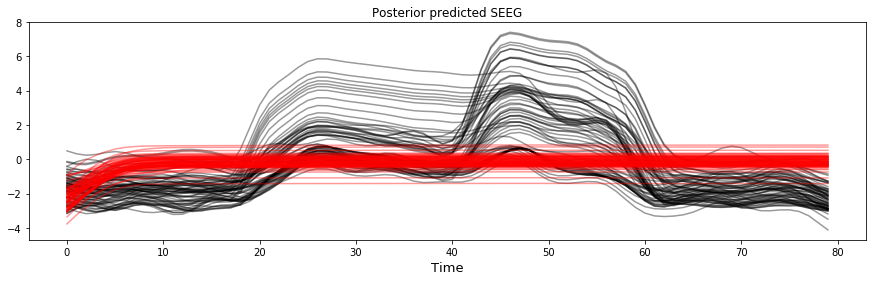

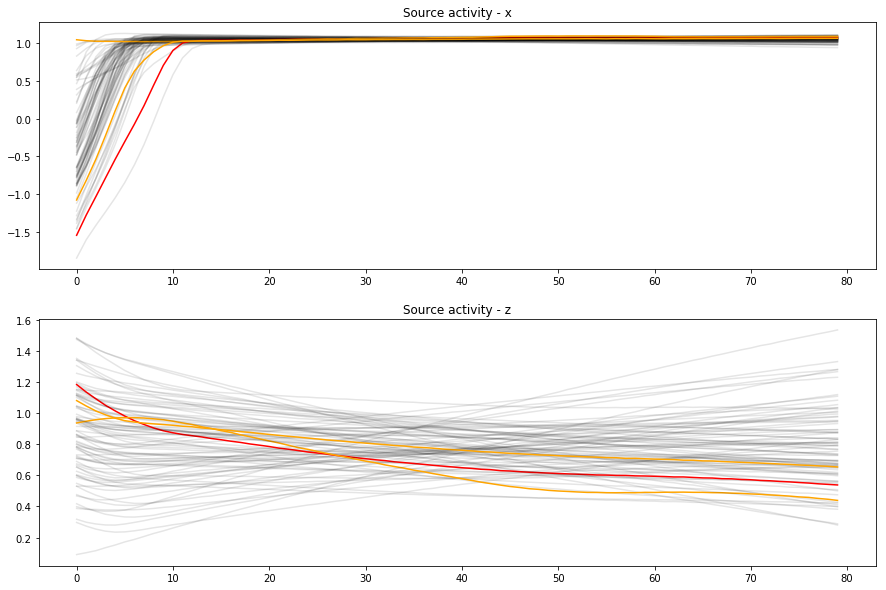

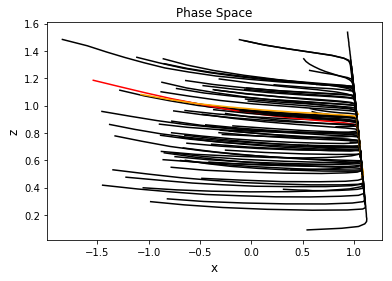

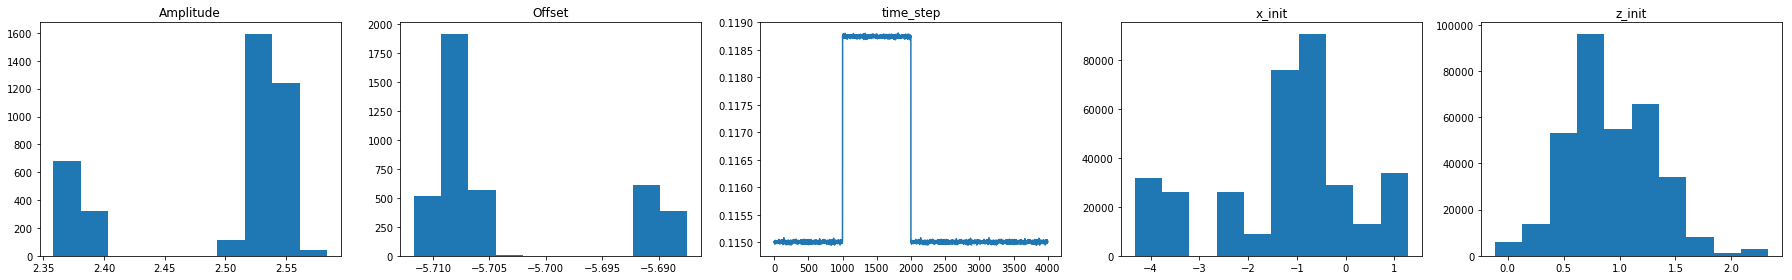

In [17]:
import importlib
importlib.reload(lib.io.stan)

nChains = 4
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_sigma0.00100_\
eps0.10000_chain{i+1}.csv' for i in range(nChains)])

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

lib.plots.stan.x0_violin(pstr_samples_1['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_sigma0.00100_eps0.10000.png')

ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude']
offset = pstr_samples_1['offset']
slp = np.zeros([src_sig.shape[0],src_sig.shape[1],gain.shape[0]])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])

slp_mean = np.mean(slp, axis=0)

mdld_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')
plt.figure(figsize=(15,4))
plt.plot(mdld_data_ds,'k',alpha=0.4);
plt.plot(slp_mean, 'r', alpha=0.4);
plt.title('Posterior predicted SEEG')
plt.xlabel('Time', fontsize=13)
plt.savefig(f'{results_dir}/figures/ppc_sigma0.00100_eps0.10000.png')


x_mean = np.mean(pstr_samples_1['x'], axis=0)
z_mean = np.mean(pstr_samples_1['z'], axis=0)

plt.figure(figsize=(15, 10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(x_mean[:, i], color='red');
        ax_src_z.plot(z_mean[:, i], color='red');
    elif i in pz:
        ax_src_x.plot(x_mean[:, i], color='orange');
        ax_src_z.plot(z_mean[:, i], color='orange');
    else:
        ax_src_x.plot(x_mean[:, i], color='black', alpha=0.1);
        ax_src_z.plot(z_mean[:, i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")
plt.savefig(f'{results_dir}/figures/src_inferred_sigma0.00100_eps0.10000.png')

plt.figure()
for i in range(84):
    if i in ez: 
        plt.plot(x_mean[:, i], z_mean[:, i], color='red')
    elif i in pz:
        plt.plot(x_mean[:, i], z_mean[:, i], color='orange')
    else:
        plt.plot(x_mean[:, i], z_mean[:, i], color='black')
plt.xlabel('x', fontsize=12.0)
plt.ylabel('z', fontsize=12.0)
plt.title('Phase Space')


plt.figure(figsize=(25,4))
plt.subplot(151)
plt.hist(pstr_samples_1['amplitude'].flatten())
plt.title('Amplitude')
plt.subplot(152)
plt.hist(pstr_samples_1['offset'].flatten())
plt.title('Offset')
plt.subplot(153)
plt.plot(pstr_samples_1['time_step'])
plt.title('time_step')
plt.subplot(154)
plt.hist(pstr_samples_1['x_init'].flatten())
plt.title('x_init')
plt.subplot(155)
plt.hist(pstr_samples_1['z_init'].flatten())
plt.title('z_init')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/other_params_sigma0.00100_eps0.10000.png')
